Import

In [ ]:
seed = 390

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

2.14.0


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
os.chdir('/gdrive/My Drive/Colab Notebooks')

Mounted at /gdrive


Data Treatment

In [ ]:
leafs_data = np.load("new_public_data.npz", allow_pickle=True)
data_leafs = np.array(leafs_data["array1"]).astype(int)
labels = np.array(leafs_data['array2'])
labels = pd.DataFrame(labels)
labels.describe()
# Turning the classes into a binary coding 00:Unhealthy, 01:Healthy
unique = labels.iloc[: , 0].unique()

loc = [1,2]
for pos in zip(loc , unique):
    labels.insert(pos[0] , pos[1] , pos[0] - 1)

labels_1 = labels
labels_1.loc[labels[0] == 'healthy' , 'healthy'] = 1
labels_1.loc[labels[0] == 'healthy', 'unhealthy'] = 0
labels = labels_1
labels = labels.drop(columns = 0)

labels_leafs = np.expand_dims(labels_leafs, axis=-1)
values_leafs = np.array([])
num = 0
for i in labels_leafs:
  if i == "healthy":
    values_leafs = np.append(values_leafs, [0])
  else:
    values_leafs = np.append(values_leafs, [1])
values_leafs = np.expand_dims(values_leafs, axis=-1)

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data_leafs,
    labels,
    test_size = 0.1,
    random_state=seed,
    stratify=labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = len(X_test), # Ensure validation set size matches test set size
    random_state=seed,
    stratify=y_train_val
)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]
batch_size = 64
epochs = 300

Model

In [ ]:
V2B0 = tfk.applications.EfficientNetV2B0(
    input_shape = input_shape,
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
V2B0.trainable = False

inputs = tfk.Input(shape=input_shape)

x = V2B0(inputs, training=False)

classifier_layer = tfkl.Dense(
    units=8,
    activation='relu',
    name='dense1'
)(x)

dropout = tfkl.Dropout(
    0.5,
    seed=seed
)(classifier_layer)

outputs = tfkl.Dense(
    units=output_shape,
    activation='softmax',
    name='dense2'
)(dropout)

model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])


24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 dense1 (Dense)              (None, 8)                 10248     
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense2 (Dense)              (None, 2)                 18        
                                                                 
Total params: 5929578 (22.62 MB)
Trainable params: 10266 (40.10 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

Training

In [ ]:
patience=40
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, mode='max', restore_best_weights=True)
lr_patience = 5
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',# Metric to monitor (validation mean squared error in this case)
    patience=patience/5,   # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.5,            # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-5            # Minimum learning rate
)
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
).history

Epoch 1/300
63/63 [==============================] - 24s 102ms/step - loss: 0.6277 - accuracy: 0.6479 - val_loss: 0.5474 - val_accuracy: 0.7126 - lr: 0.0010
Epoch 2/300
63/63 [==============================] - 3s 43ms/step - loss: 0.5459 - accuracy: 0.7169 - val_loss: 0.4812 - val_accuracy: 0.7924 - lr: 0.0010
Epoch 3/300
63/63 [==============================] - 2s 35ms/step - loss: 0.5076 - accuracy: 0.7464 - val_loss: 0.4471 - val_accuracy: 0.8204 - lr: 0.0010
Epoch 4/300
63/63 [==============================] - 2s 32ms/step - loss: 0.4901 - accuracy: 0.7631 - val_loss: 0.4270 - val_accuracy: 0.8184 - lr: 0.0010
Epoch 5/300
63/63 [==============================] - 2s 34ms/step - loss: 0.4740 - accuracy: 0.7596 - val_loss: 0.4166 - val_accuracy: 0.8204 - lr: 0.0010
Epoch 6/300
63/63 [==============================] - 2s 32ms/step - loss: 0.4530 - accuracy: 0.7826 - val_loss: 0.4143 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 7/300
63/63 [==============================] - 2s 34ms/step - 

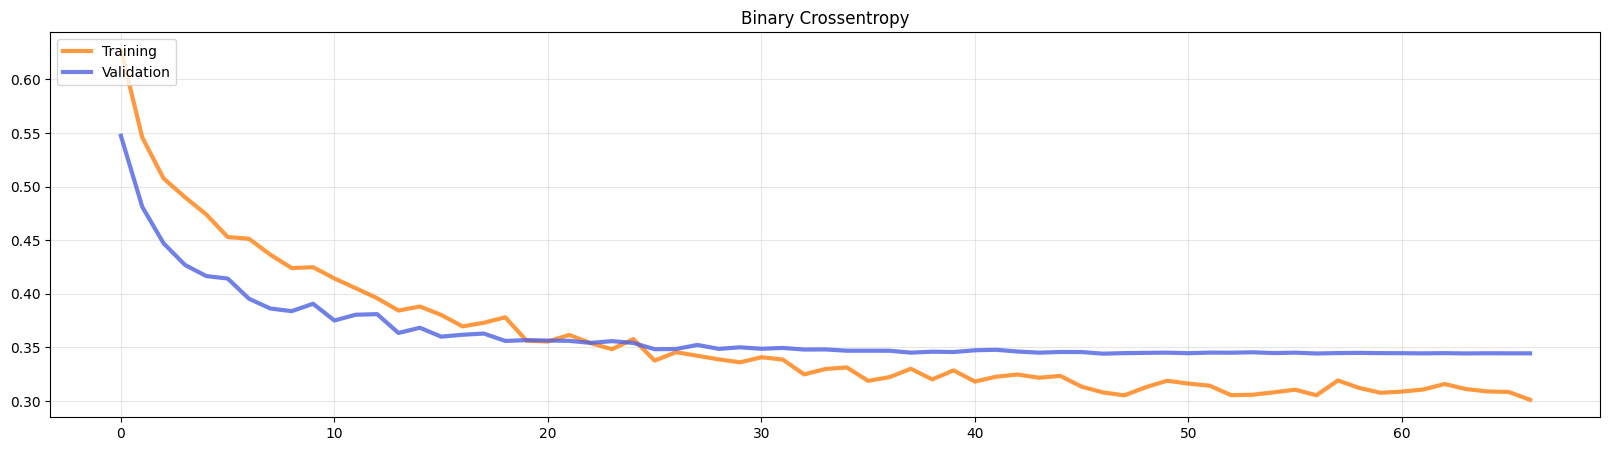

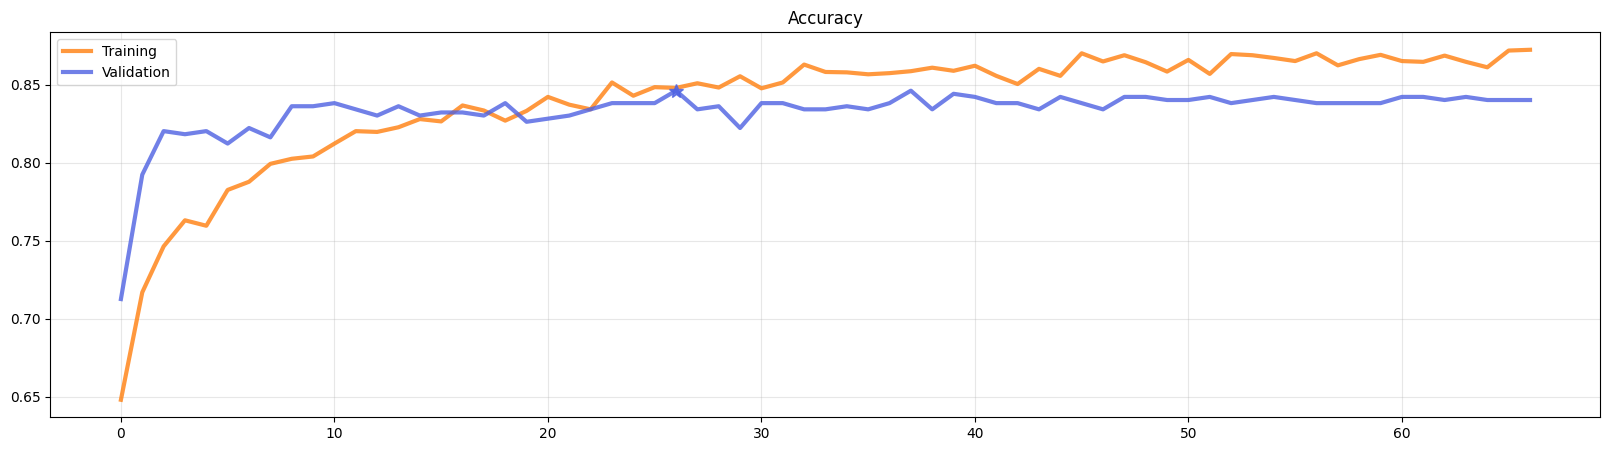

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

Predictions Shape: (501, 2)
Accuracy: 0.8623
Precision: 0.8625
Recall: 0.8425
F1: 0.8502


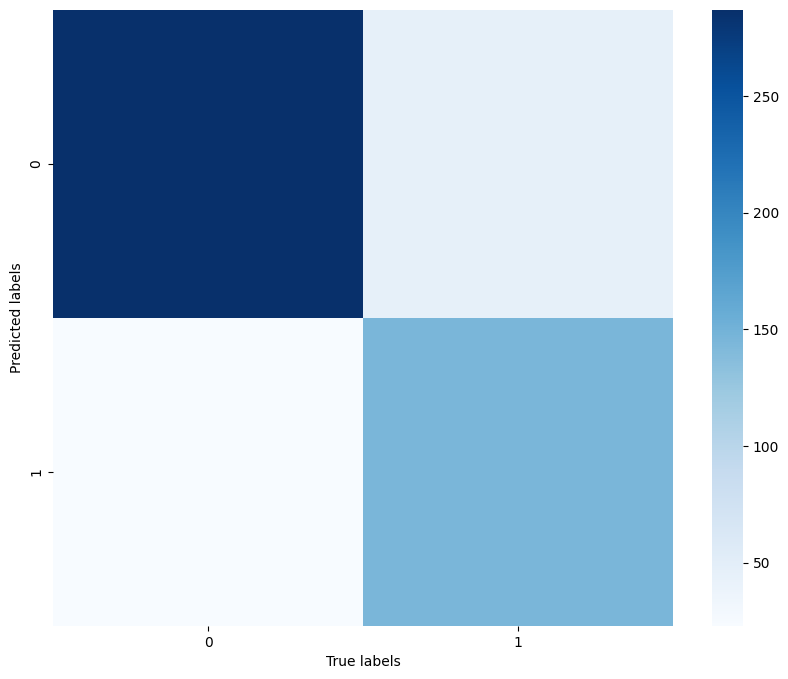

In [ ]:
predictions = model.predict(X_test, verbose=0)
print("Predictions Shape:", predictions.shape)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1))
precision = precision_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1), average='macro')
recall = recall_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1), average='macro')
f1 = f1_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels={0, 1}, yticklabels={0, 1}, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

Fine Tuning

In [ ]:
ft_model = model
ft_model = tfk.models.load_model('V2B0')
ft_model.get_layer('efficientnetv2-b0').trainable = True
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-b0').layers):
   print(i, layer.name, layer.trainable)
N = 100
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-b0').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-b0').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 True
1 rescaling True
2 normalization True
3 stem_conv True
4 stem_bn True
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn True
8 block1a_project_activation True
9 block2a_expand_conv True
10 block2a_expand_bn True
11 block2a_expand_activation True
12 block2a_project_conv True
13 block2a_project_bn True
14 block2b_expand_conv True
15 block2b_expand_bn True
16 block2b_expand_activation True
17 block2b_project_conv True
18 block2b_project_bn True
19 block2b_drop True
20 block2b_add True
21 block3a_expand_conv True
22 block3a_expand_bn True
23 block3a_expand_activation True
24 block3a_project_conv True
25 block3a_project_bn True
26 block3b_expand_conv True
27 block3b_expand_bn True
28 block3b_expand_activation True
29 block3b_project_conv True
30 block3b_project_bn True
31 block3b_drop True
32 block3b_add True
33 block4a_expand_conv True
34 block4a_expand_bn True
35 block4a_expand_activation True
36 block4a_dwconv2 True
37 block4a_bn True
38 block4a_activ

Predictions Shape: (501, 2)
Accuracy: 0.8623
Precision: 0.8625
Recall: 0.8425
F1: 0.8502


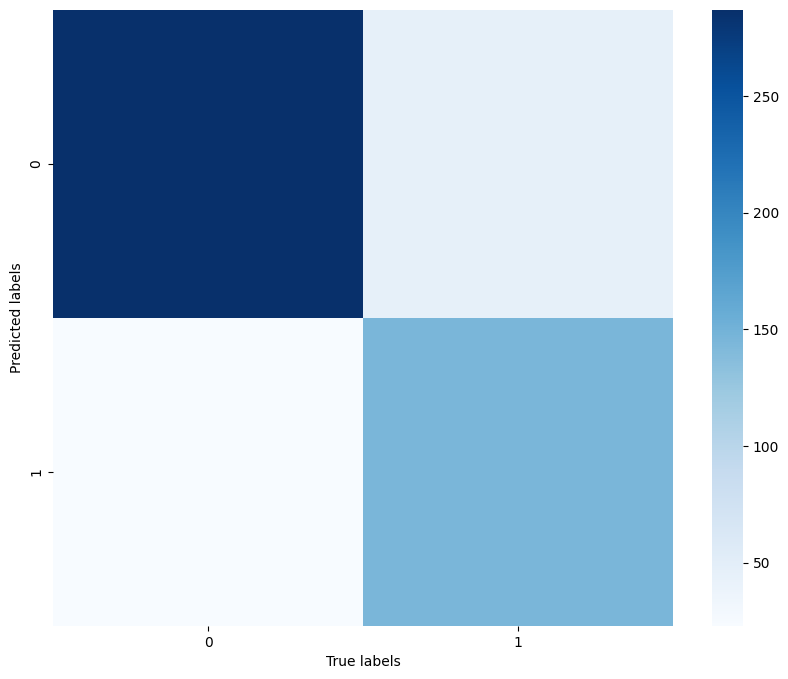

In [ ]:
predictions = ft_model.predict(X_test, verbose=0)
print("Predictions Shape:", predictions.shape)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1))
precision = precision_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1), average='macro')
recall = recall_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1), average='macro')
f1 = f1_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels={0, 1}, yticklabels={0, 1}, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])
patience=40
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, mode='max', restore_best_weights=False)
lr_patience = 5
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',# Metric to monitor (validation mean squared error in this case)
    patience=patience/5,   # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.5,            # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7            # Minimum learning rate
)

In [ ]:
history_ft = ft_model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
).history

Epoch 1/300
63/63 [==============================] - 38s 123ms/step - loss: 0.3447 - accuracy: 0.8498 - val_loss: 0.3430 - val_accuracy: 0.8363 - lr: 1.0000e-05
Epoch 2/300
63/63 [==============================] - 5s 87ms/step - loss: 0.3215 - accuracy: 0.8601 - val_loss: 0.3386 - val_accuracy: 0.8463 - lr: 1.0000e-05
Epoch 3/300
63/63 [==============================] - 6s 90ms/step - loss: 0.3049 - accuracy: 0.8678 - val_loss: 0.3340 - val_accuracy: 0.8363 - lr: 1.0000e-05
Epoch 4/300
63/63 [==============================] - 5s 84ms/step - loss: 0.2854 - accuracy: 0.8746 - val_loss: 0.3410 - val_accuracy: 0.8443 - lr: 1.0000e-05
Epoch 5/300
63/63 [==============================] - 7s 108ms/step - loss: 0.2801 - accuracy: 0.8738 - val_loss: 0.3289 - val_accuracy: 0.8363 - lr: 1.0000e-05
Epoch 6/300
63/63 [==============================] - 5s 86ms/step - loss: 0.2617 - accuracy: 0.8818 - val_loss: 0.3304 - val_accuracy: 0.8503 - lr: 1.0000e-05
Epoch 7/300
63/63 [========================

Predictions Shape: (501, 2)
Accuracy: 0.8822
Precision: 0.8755
Recall: 0.8747
F1: 0.8751


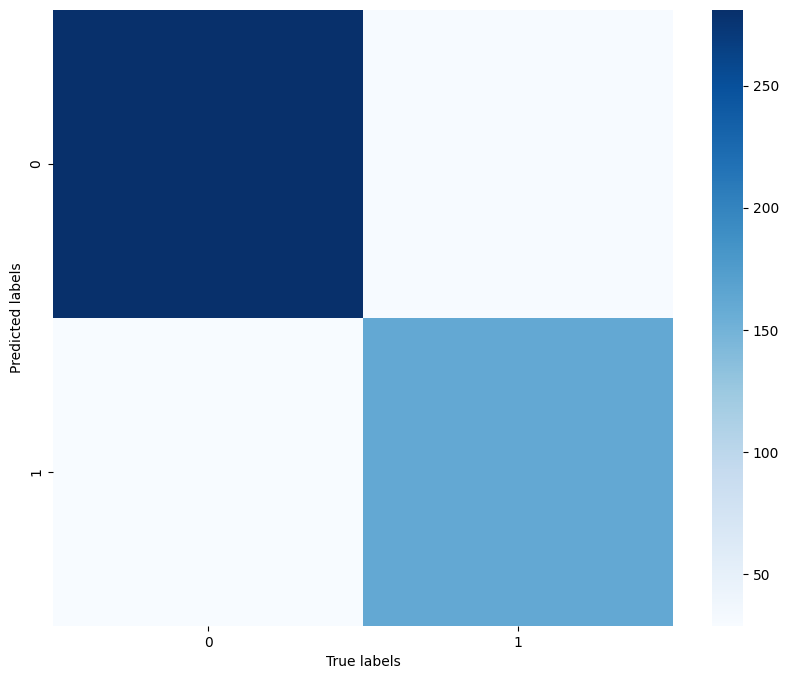

In [ ]:
predictions = ft_model.predict(X_test, verbose=0)
print("Predictions Shape:", predictions.shape)
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1))
precision = precision_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1), average='macro')
recall = recall_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1), average='macro')
f1 = f1_score(np.argmax(y_test.values, axis=1), np.argmax(predictions, axis=1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels={0, 1}, yticklabels={0, 1}, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
ft_model.save("V2B0_ft_n.h5")